A part of the code of this program is referenced from below:

Li, S (2018) A Beginner's Guide on Sentiment Analysis with RNN [Source code]. https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import re
import os
import sklearn

from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

# Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# calculate F1 score
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

In [ ]:
# read csv file
df = pd.read_csv('new_clean_data.csv', encoding = 'utf-8')
df = df.drop(df.columns[[0]], axis=1)

In [ ]:
df

,type,clean_posts
0,INFJ,enfp intj moments sportscenter top ten play pr...
1,ENTP,find lack post alarm sex bore position often e...
2,INTP,good one course say know bless curse absolutel...
3,INTJ,dear intp enjoy conversation day esoteric gabb...
4,ENTJ,you fire another silly misconception approach ...
...,...,...
9215,ESFJ,every time show tell mom something funny turn...
9216,ESTJ,bike elliptical already 10 miles morning ...
9217,ENFJ,sigh sleep half day feel ill ugh agm quality ...
9218,ENFJ,hahaha yess begin first veishea aahh plan wa...


In [ ]:
# divide into four binary classifications
df['is_Extrovert'] = [1 if x[0]=='E' else 0 for x in df['type']]
df['is_Sensing'] = [1 if x[1]=='S' else 0 for x in df['type']]
df['is_Thinking'] = [1 if x[2]=='T' else 0 for x in df['type']]
df['is_Judging'] = [1 if x[3]=='J' else 0 for x in df['type']]
df

,type,clean_posts,is_Extrovert,is_Sensing,is_Thinking,is_Judging
0,INFJ,enfp intj moments sportscenter top ten play pr...,0,0,0,1
1,ENTP,find lack post alarm sex bore position often e...,1,0,1,0
2,INTP,good one course say know bless curse absolutel...,0,0,1,0
3,INTJ,dear intp enjoy conversation day esoteric gabb...,0,0,1,1
4,ENTJ,you fire another silly misconception approach ...,1,0,1,1
...,...,...,...,...,...,...
9215,ESFJ,every time show tell mom something funny turn...,1,1,0,1
9216,ESTJ,bike elliptical already 10 miles morning ...,1,1,1,1
9217,ENFJ,sigh sleep half day feel ill ugh agm quality ...,1,0,0,1
9218,ENFJ,hahaha yess begin first veishea aahh plan wa...,1,0,0,1


In [ ]:
# count the number of each categories

i_count = df["is_Extrovert"].value_counts()[0]
e_count = df["is_Extrovert"].value_counts()[1]

n_count = df["is_Sensing"].value_counts()[0]
s_count = df["is_Sensing"].value_counts()[1]

f_count = df["is_Thinking"].value_counts()[0]
t_count = df["is_Thinking"].value_counts()[1]

p_count = df["is_Judging"].value_counts()[0]
j_count = df["is_Judging"].value_counts()[1]


In [ ]:
print(f"No. of Introverts: {i_count}")
print(f"No. of Extroverts: {e_count}")
print(f"No. of Intuition: {n_count}")
print(f"No. of Sensing: {s_count}")
print(f"No. of Feelings: {f_count}")
print(f"No. of Thinking: {t_count}")
print(f"No. of Perceiving: {p_count}")
print(f"No. of Judging: {j_count}")

No. of Introverts: 6901
No. of Extroverts: 2319
No. of Intuition: 7685
No. of Sensing: 1535
No. of Feelings: 4989
No. of Thinking: 4231
No. of Perceiving: 5355
No. of Judging: 3865


In [ ]:
df

,type,clean_posts,is_Extrovert,is_Sensing,is_Thinking,is_Judging
0,INFJ,enfp intj moments sportscenter top ten play pr...,0,0,0,1
1,ENTP,find lack post alarm sex bore position often e...,1,0,1,0
2,INTP,good one course say know bless curse absolutel...,0,0,1,0
3,INTJ,dear intp enjoy conversation day esoteric gabb...,0,0,1,1
4,ENTJ,you fire another silly misconception approach ...,1,0,1,1
...,...,...,...,...,...,...
9215,ESFJ,every time show tell mom something funny turn...,1,1,0,1
9216,ESTJ,bike elliptical already 10 miles morning ...,1,1,1,1
9217,ENFJ,sigh sleep half day feel ill ugh agm quality ...,1,0,0,1
9218,ENFJ,hahaha yess begin first veishea aahh plan wa...,1,0,0,1


# Data Processing

In [ ]:
# Find the average length of all posts for padding

sum_word = 0
for x in df['clean_posts']:
    y = x.split(' ')
    sum_word += len(y)
print(round(sum_word/len(df)))


1039


In [ ]:
from collections import Counter

#Count unique words
def counter_word(post_col):
    count = Counter()
    for t in post_col.values:
        for word in t.split():
            count[word]+=1
    return count
counter = counter_word(df.clean_posts)

In [ ]:
len(counter)

350281

In [ ]:
counter


Counter({'enfp': 8762,
         'intj': 11804,
         'moments': 983,
         'sportscenter': 7,
         'top': 3720,
         'ten': 820,
         'play': 11882,
         'prank': 187,
         'life': 24092,
         'change': 9377,
         'experience': 8963,
         'repeat': 1011,
         'today': 14919,
         'may': 10621,
         'perc': 1568,
         'immerse': 104,
         'last': 13117,
         'thing': 19665,
         'infj': 12362,
         'friend': 13419,
         'post': 18266,
         'facebook': 2278,
         'commit': 765,
         'suicide': 469,
         'next': 7118,
         'day': 20829,
         'rest': 2851,
         'peace': 1196,
         'hello': 3799,
         'enfj7': 1,
         'sorry': 7760,
         'hear': 9784,
         'distress': 161,
         'natural': 1671,
         'relationship': 7057,
         'perfection': 285,
         'time': 49745,
         'every': 11429,
         'moment': 4078,
         'existence': 734,
         'try':

In [ ]:
counter.most_common(10)

[('like', 101386),
 ('think', 85896),
 ('get', 84013),
 ('go', 64429),
 ('know', 63543),
 ('people', 61259),
 ('one', 54300),
 ('would', 53204),
 ('make', 53073),
 ('say', 49986)]

In [ ]:
num_unique_words = len(counter)


In [ ]:
# Split dataset into training and validation set
train_size = int(df.shape[0] * 0.8)

train_df = df[:train_size]
val_df = df[train_size:]

# split text and labels
train_sentences = train_df.clean_posts.to_numpy()
train_labels = train_df.is_Extrovert.to_numpy()
val_sentences = val_df.clean_posts.to_numpy()
val_labels = val_df.is_Extrovert.to_numpy()

In [ ]:
train_sentences.shape, val_sentences.shape

((7376,), (1844,))

In [ ]:
from keras_preprocessing.text import tokenizer_from_json
import io
import json

# vectorize a text corpus by turning each text into a sequence of integers

tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) # fit only to training

tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))


In [ ]:
word_index = tokenizer.word_index

In [ ]:
len(tokenizer.word_index)

86622

In [ ]:
# turn tokens into sequences

train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [ ]:

# Average the number of words in a sequence

avg_length = 1039

train_padded = pad_sequences(train_sequences, maxlen=avg_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=avg_length, padding="post", truncating="post")
train_padded.shape, val_padded.shape



((7376, 1039), (1844, 1039))

In [ ]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [ ]:
reverse_word_index

{1: 'like',
 2: 'think',
 3: 'get',
 4: 'people',
 5: 'know',
 6: 'would',
 7: 'say',
 8: 'feel',
 9: 'one',
 10: 'go',
 11: 'really',
 12: 'make',
 13: 'time',
 14: 'want',
 15: 'type',
 16: 'see',
 17: 'love',
 18: 'much',
 19: 'well',
 20: 'find',
 21: 'good',
 22: 'things',
 23: 'try',
 24: 'way',
 25: 'something',
 26: 'take',
 27: 'lot',
 28: 'also',
 29: 'use',
 30: 'could',
 31: 'even',
 32: 'work',
 33: 'always',
 34: 'look',
 35: 'come',
 36: 'someone',
 37: 'life',
 38: 'mean',
 39: 'seem',
 40: 'thank',
 41: 'never',
 42: 'read',
 43: 'need',
 44: 'though',
 45: 'thing',
 46: 'post',
 47: 'talk',
 48: 'interest',
 49: 'infp',
 50: 'tell',
 51: 'right',
 52: 'actually',
 53: 'person',
 54: 'first',
 55: 'yes',
 56: 'give',
 57: 'sure',
 58: 'infj',
 59: 'pretty',
 60: 'friends',
 61: 'intj',
 62: 'guy',
 63: 'still',
 64: 'understand',
 65: 'kind',
 66: 'thread',
 67: '1',
 68: 'start',
 69: 'laugh',
 70: 'intp',
 71: 'many',
 72: 'friend',
 73: 'sometimes',
 74: 'probably',

In [ ]:
len(train_padded)

7376

In [ ]:
#Split some train data for validation during training (80:20)
partial_train_padded = train_padded[:5901]
train_val_padded = train_padded[5901:]

partial_train_labels = train_labels[:5901]
train_val_labels = train_labels[5901:]

print(len(partial_train_padded), len(train_val_padded))

5901 1475


In [ ]:
print('partial_train shape: ', partial_train_padded.shape)
print('train_validation shape: ', train_val_padded.shape)

partial_train shape:  (5901, 1039)
train_validation shape:  (1475, 1039)


In [ ]:
# import ROS
from imblearn.over_sampling import RandomOverSampler

ROS = RandomOverSampler(sampling_strategy=1)
partial_train_ros, partial_train_labels_ros = ROS.fit_resample(partial_train_padded, partial_train_labels)

In [ ]:
Counter(partial_train_labels_ros)

Counter({0: 4524, 1: 4524})

In [ ]:
def get_f1(val_labels, predictions): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(val_labels * predictions, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(val_labels, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(predictions, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
#Plot learning curves

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# is_Extrovert model with ROS

In [ ]:
#Final model of is_Extrovert with RandomOverSampler
IE_model_11 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=num_unique_words,
        output_dim=16,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1, activation='ReLU')
])

IE_model_11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          5604496   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,617,105
Trainable params: 5,617,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
IE_model_11.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = '/content/ModelCheckpoints/Checkpoint-{epoch:01d}-{val_accuracy:.04f}.hdf5'
IE_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', varbose=1, save_best_only=True)

IE_model_11_history = IE_model_11.fit(partial_train_ros, partial_train_labels_ros, epochs=50, callbacks=[IE_checkpoint], validation_data=(train_val_padded, train_val_labels), verbose=2)

Epoch 1/50
283/283 - 32s - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6969 - val_accuracy: 0.7797 - 32s/epoch - 111ms/step
Epoch 2/50
283/283 - 18s - loss: 0.6697 - accuracy: 0.5632 - val_loss: 0.6934 - val_accuracy: 0.7831 - 18s/epoch - 62ms/step
Epoch 3/50
283/283 - 17s - loss: 0.6029 - accuracy: 0.7388 - val_loss: 0.7314 - val_accuracy: 0.8007 - 17s/epoch - 61ms/step
Epoch 4/50
283/283 - 17s - loss: 0.5676 - accuracy: 0.7793 - val_loss: 0.7865 - val_accuracy: 0.7953 - 17s/epoch - 59ms/step
Epoch 5/50
283/283 - 17s - loss: 0.6045 - accuracy: 0.6912 - val_loss: 0.6934 - val_accuracy: 0.8061 - 17s/epoch - 60ms/step
Epoch 6/50
283/283 - 17s - loss: 0.6028 - accuracy: 0.6800 - val_loss: 0.6926 - val_accuracy: 0.7797 - 17s/epoch - 60ms/step
Epoch 7/50
283/283 - 17s - loss: 0.6147 - accuracy: 0.6575 - val_loss: 0.8934 - val_accuracy: 0.7376 - 17s/epoch - 60ms/step
Epoch 8/50
283/283 - 17s - loss: 0.5996 - accuracy: 0.6983 - val_loss: 0.7076 - val_accuracy: 0.8251 - 17s/epoch - 59ms/step

In [ ]:
# Check model on test set
loss, accuracy = IE_model_11.evaluate(val_padded, val_labels)
print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

58/58 [==============================] - 2s 37ms/step - loss: 1.2604 - accuracy: 0.7012
Model loss on test set: 1.2603989839553833
Model accuracy on test set: 70.12%


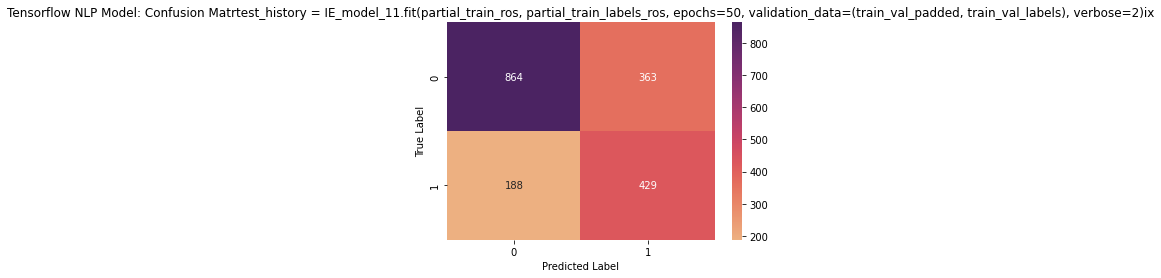

F1 Score:  0.7082767994967765


In [ ]:
# visualize perfomance with a confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = (IE_model_11.predict(val_padded) > 0.5).astype("int32")
predictions = [p[0] for p in predictions]
confusion_matrix = tf.math.confusion_matrix(val_labels, predictions)

TP = confusion_matrix.numpy()[0][0]
FP = confusion_matrix.numpy()[0][1]
FN = confusion_matrix.numpy()[1][0]
TN = confusion_matrix.numpy()[1][1]

ax = plt.axes()
sns.heatmap(confusion_matrix, cmap='flare', annot=True, fmt="d", ax = ax)
ax.set_title('Tensorflow NLP Model: Confusion Matrtest_history = IE_model_11.fit(partial_train_ros, partial_train_labels_ros, epochs=50, validation_data=(train_val_padded, train_val_labels), verbose=2)ix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

precise_F1_0 = TP/(TP+FP)
recall_F1_0 = TP/(TP+FN)
F1_0 = (2*precise_F1_0*recall_F1_0)/(recall_F1_0+precise_F1_0)

precise_F1_1 = TN/(TN+FN)
recall_F1_1 = TN/(TN+FP)
F1_1 = (2*precise_F1_1*recall_F1_1)/(recall_F1_1+precise_F1_1)

weight_0 = (TP+FP)/(TP+FP+FN+TN)
weight_1 = (FN+TN)/(TP+FP+FN+TN)
F1_score = F1_0*weight_0+F1_1*weight_1
print("F1 Score: ", F1_score)


(0.0, 1.0514509946107864)

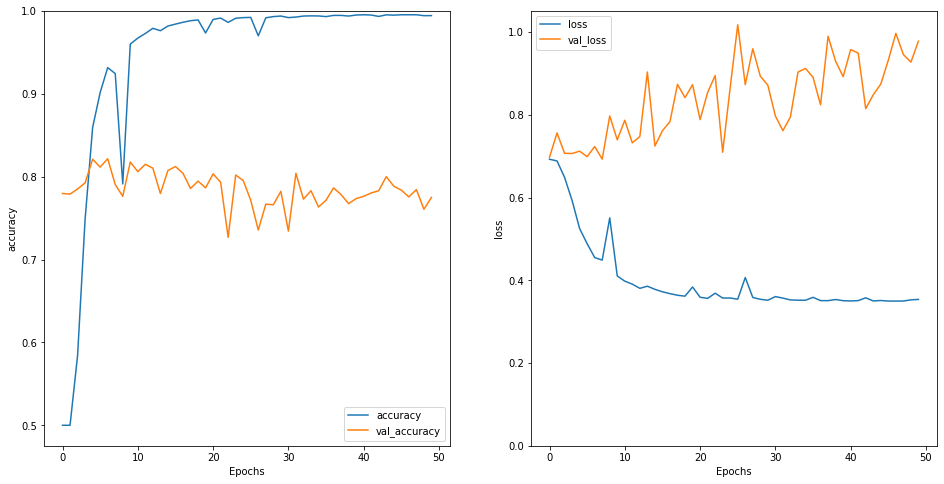

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(IE_model_11_history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(IE_model_11_history, 'loss')
plt.ylim(0, None)

In [ ]:
IE_model_11.save('models/IE.h5')

# is_Extrovert Model without ROS

In [ ]:
#is_Extrovert model without ros & LSTM(32) & activation(sigmoid)
IE_model_13 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=num_unique_words,
        output_dim=16,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1, activation='ReLU')
])

IE_model_13.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          5604496   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,617,105
Trainable params: 5,617,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
IE_model_13.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [ ]:
checkpoint_path = "IE_model_13.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        save_weights_only = True, verbose=1)

IE_model_13_history = IE_model_13.fit(partial_train_padded, partial_train_labels, epochs=50, callbacks=[callbacks], validation_data=(train_val_padded, train_val_labels), verbose=2)

Epoch 1/50

Epoch 1: saving model to IE_model_13.ckpt
185/185 - 40s - loss: 0.6932 - accuracy: 0.7666 - val_loss: 0.6931 - val_accuracy: 0.7797 - 40s/epoch - 215ms/step
Epoch 2/50

Epoch 2: saving model to IE_model_13.ckpt
185/185 - 12s - loss: 0.6931 - accuracy: 0.7666 - val_loss: 0.6931 - val_accuracy: 0.7797 - 12s/epoch - 63ms/step
Epoch 3/50

Epoch 3: saving model to IE_model_13.ckpt
185/185 - 12s - loss: 0.6931 - accuracy: 0.7666 - val_loss: 0.6931 - val_accuracy: 0.7797 - 12s/epoch - 62ms/step
Epoch 4/50

Epoch 4: saving model to IE_model_13.ckpt
185/185 - 12s - loss: 0.6931 - accuracy: 0.7666 - val_loss: 0.6931 - val_accuracy: 0.7797 - 12s/epoch - 63ms/step
Epoch 5/50

Epoch 5: saving model to IE_model_13.ckpt
185/185 - 12s - loss: 0.6931 - accuracy: 0.7666 - val_loss: 0.6932 - val_accuracy: 0.7797 - 12s/epoch - 65ms/step
Epoch 6/50

Epoch 6: saving model to IE_model_13.ckpt
185/185 - 12s - loss: 0.6931 - accuracy: 0.7666 - val_loss: 0.6931 - val_accuracy: 0.7797 - 12s/epoch - 6

In [ ]:
# Check the accuracy of our model
loss, accuracy = IE_model_13.evaluate(val_padded, val_labels)
print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

58/58 [==============================] - 2s 41ms/step - loss: 0.7615 - accuracy: 0.7131
Model loss on test set: 0.7615087628364563
Model accuracy on test set: 71.31%


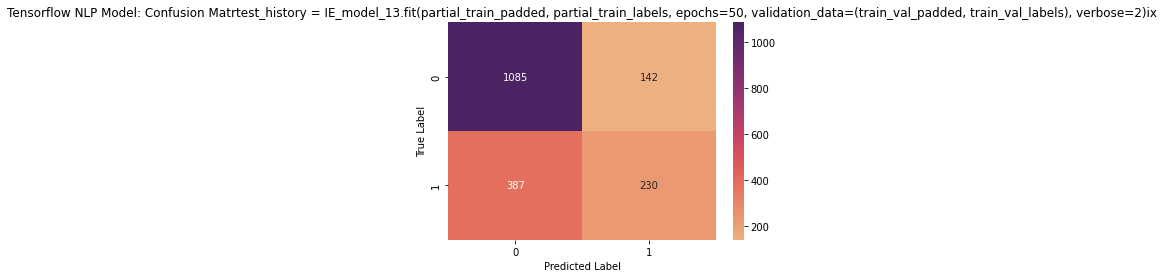

F1 Score:  0.6906109341851001


In [ ]:
# visualize perfomance with a confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = (IE_model_13.predict(val_padded) > 0.5).astype("int32")
predictions = [p[0] for p in predictions]
confusion_matrix = tf.math.confusion_matrix(val_labels, predictions)

TP = confusion_matrix.numpy()[0][0]
FP = confusion_matrix.numpy()[0][1]
FN = confusion_matrix.numpy()[1][0]
TN = confusion_matrix.numpy()[1][1]

ax = plt.axes()
sns.heatmap(confusion_matrix, cmap='flare', annot=True, fmt="d", ax = ax)
ax.set_title('Tensorflow NLP Model: Confusion Matrtest_history = IE_model_13.fit(partial_train_padded, partial_train_labels, epochs=50, validation_data=(train_val_padded, train_val_labels), verbose=2)ix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

precise_F1_0 = TP/(TP+FP)
recall_F1_0 = TP/(TP+FN)
F1_0 = (2*precise_F1_0*recall_F1_0)/(recall_F1_0+precise_F1_0)

precise_F1_1 = TN/(TN+FN)
recall_F1_1 = TN/(TN+FP)
F1_1 = (2*precise_F1_1*recall_F1_1)/(recall_F1_1+precise_F1_1)

weight_0 = (TP+FP)/(TP+FP+FN+TN)
weight_1 = (FN+TN)/(TP+FP+FN+TN)
F1_score = F1_0*weight_0+F1_1*weight_1
print("F1 Score: ", F1_score)


# is_Sensing model with ROS

In [ ]:
#Final is_Sensing model with ros
NS_model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=num_unique_words,
        output_dim=16,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1, activation='ReLU')
])

NS_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          5604496   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,617,105
Trainable params: 5,617,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NS_model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = '/content/NS/-{epoch:01d}-{val_accuracy:.04f}.hdf5'
NS_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', varbose=1, save_best_only=True)

NS_model_1_history = NS_model_1.fit(partial_train_ros, partial_train_labels_ros, epochs=50, callbacks=[NS_checkpoint], validation_data=(train_val_padded, train_val_labels), verbose=2)

Epoch 1/50
320/320 - 39s - loss: 0.6925 - accuracy: 0.5000 - val_loss: 0.6980 - val_accuracy: 0.8461 - 39s/epoch - 123ms/step
Epoch 2/50
320/320 - 25s - loss: 0.6873 - accuracy: 0.5323 - val_loss: 0.9808 - val_accuracy: 0.6949 - 25s/epoch - 78ms/step
Epoch 3/50
320/320 - 25s - loss: 0.6333 - accuracy: 0.5786 - val_loss: 0.7058 - val_accuracy: 0.8461 - 25s/epoch - 78ms/step
Epoch 4/50
320/320 - 26s - loss: 0.5774 - accuracy: 0.7581 - val_loss: 0.7017 - val_accuracy: 0.8447 - 26s/epoch - 81ms/step
Epoch 5/50
320/320 - 17s - loss: 0.5885 - accuracy: 0.7167 - val_loss: 0.7257 - val_accuracy: 0.8461 - 17s/epoch - 52ms/step
Epoch 6/50
320/320 - 17s - loss: 0.5619 - accuracy: 0.8133 - val_loss: 0.9211 - val_accuracy: 0.7532 - 17s/epoch - 53ms/step
Epoch 7/50
320/320 - 17s - loss: 0.5181 - accuracy: 0.8695 - val_loss: 0.7574 - val_accuracy: 0.8461 - 17s/epoch - 53ms/step
Epoch 8/50
320/320 - 17s - loss: 0.4622 - accuracy: 0.9271 - val_loss: 0.7621 - val_accuracy: 0.8414 - 17s/epoch - 52ms/step

In [ ]:
# Check the accuracy of our model
loss, accuracy = NS_model_1.evaluate(val_padded, val_labels)
print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

58/58 [==============================] - 2s 29ms/step - loss: 1.0189 - accuracy: 0.7435
Model loss on test set: 1.018898367881775
Model accuracy on test set: 74.35%


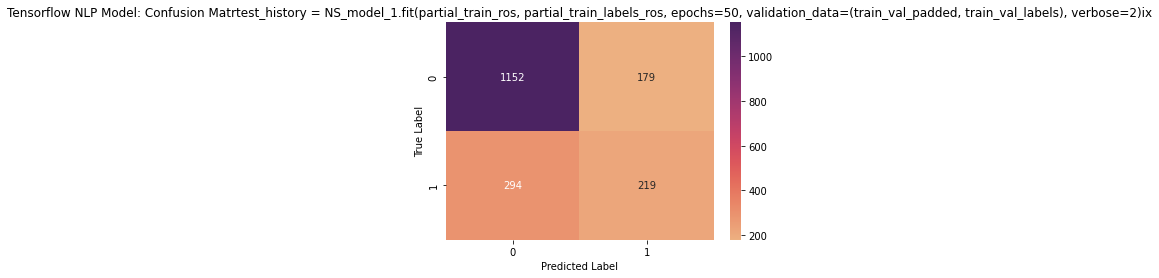

F1 Score:  0.7326134961183555


In [ ]:
# visualize perfomance with a confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = (NS_model_1.predict(val_padded) > 0.5).astype("int32")
predictions = [p[0] for p in predictions]
confusion_matrix = tf.math.confusion_matrix(val_labels, predictions)

TP = confusion_matrix.numpy()[0][0]
FP = confusion_matrix.numpy()[0][1]
FN = confusion_matrix.numpy()[1][0]
TN = confusion_matrix.numpy()[1][1]

ax = plt.axes()
sns.heatmap(confusion_matrix, cmap='flare', annot=True, fmt="d", ax = ax)
ax.set_title('Tensorflow NLP Model: Confusion Matrtest_history = NS_model_1.fit(partial_train_ros, partial_train_labels_ros, epochs=50, validation_data=(train_val_padded, train_val_labels), verbose=2)ix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

precise_F1_0 = TP/(TP+FP)
recall_F1_0 = TP/(TP+FN)
F1_0 = (2*precise_F1_0*recall_F1_0)/(recall_F1_0+precise_F1_0)

precise_F1_1 = TN/(TN+FN)
recall_F1_1 = TN/(TN+FP)
F1_1 = (2*precise_F1_1*recall_F1_1)/(recall_F1_1+precise_F1_1)

weight_0 = (TP+FP)/(TP+FP+FN+TN)
weight_1 = (FN+TN)/(TP+FP+FN+TN)
F1_score = F1_0*weight_0+F1_1*weight_1
print("F1 Score: ", F1_score)


(0.0, 0.8875466495752334)

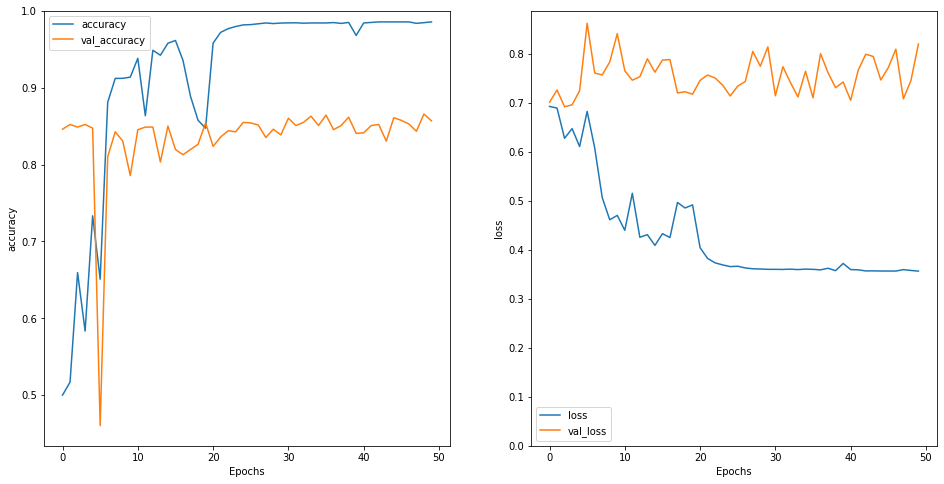

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(NS_model_1_history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(NS_model_1_history, 'loss')
plt.ylim(0, None)

In [ ]:
NS_model_1.save('/content/NS.h5')

# is_Sensing model without ROS

In [ ]:
#is_Sensing model without ros 
NS_model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=num_unique_words,
        output_dim=16,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1, activation='ReLU')
])

NS_model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          5604496   
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,617,105
Trainable params: 5,617,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NS_model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [ ]:
checkpoint_path = "NS_model_3.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        save_weights_only = True, verbose=1)

NS_model_3_history = NS_model_3.fit(partial_train_padded, partial_train_labels, epochs=50, callbacks=[callbacks], validation_data=(train_val_padded, train_val_labels), verbose=2)

Epoch 1/50

Epoch 1: saving model to NS_model_3.ckpt
185/185 - 28s - loss: 0.6932 - accuracy: 0.8653 - val_loss: 0.6931 - val_accuracy: 0.8461 - 28s/epoch - 152ms/step
Epoch 2/50

Epoch 2: saving model to NS_model_3.ckpt
185/185 - 13s - loss: 0.6931 - accuracy: 0.8653 - val_loss: 0.6931 - val_accuracy: 0.8461 - 13s/epoch - 69ms/step
Epoch 3/50

Epoch 3: saving model to NS_model_3.ckpt
185/185 - 13s - loss: 0.6931 - accuracy: 0.8653 - val_loss: 0.6931 - val_accuracy: 0.8461 - 13s/epoch - 71ms/step
Epoch 4/50

Epoch 4: saving model to NS_model_3.ckpt
185/185 - 13s - loss: 0.6931 - accuracy: 0.8653 - val_loss: 0.6931 - val_accuracy: 0.8461 - 13s/epoch - 68ms/step
Epoch 5/50

Epoch 5: saving model to NS_model_3.ckpt
185/185 - 13s - loss: 0.6931 - accuracy: 0.8653 - val_loss: 0.6931 - val_accuracy: 0.8461 - 13s/epoch - 68ms/step
Epoch 6/50

Epoch 6: saving model to NS_model_3.ckpt
185/185 - 13s - loss: 0.6931 - accuracy: 0.8653 - val_loss: 0.6931 - val_accuracy: 0.8461 - 13s/epoch - 72ms/st

In [ ]:
# Check the accuracy of our model
loss, accuracy = NS_model_3.evaluate(val_padded, val_labels)
print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

58/58 [==============================] - 4s 59ms/step - loss: 0.7206 - accuracy: 0.7386
Model loss on test set: 0.720635712146759
Model accuracy on test set: 73.86%


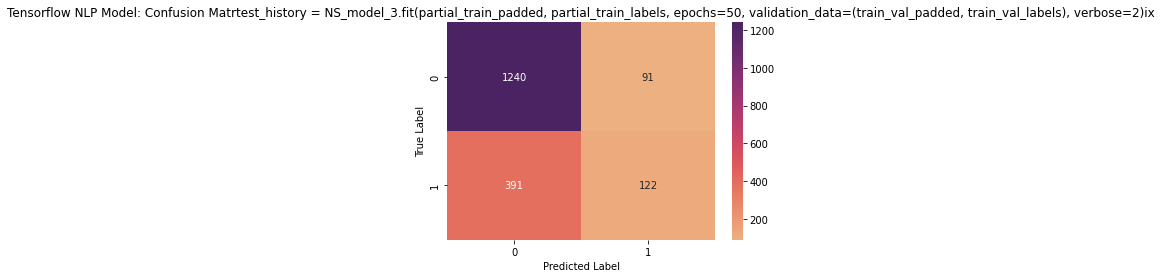

F1 Score:  0.6978429534300249


In [ ]:
# visualize perfomance with a confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = (NS_model_3.predict(val_padded) > 0.5).astype("int32")
predictions = [p[0] for p in predictions]
confusion_matrix = tf.math.confusion_matrix(val_labels, predictions)

TP = confusion_matrix.numpy()[0][0]
FP = confusion_matrix.numpy()[0][1]
FN = confusion_matrix.numpy()[1][0]
TN = confusion_matrix.numpy()[1][1]

ax = plt.axes()
sns.heatmap(confusion_matrix, cmap='flare', annot=True, fmt="d", ax = ax)
ax.set_title('Tensorflow NLP Model: Confusion Matrtest_history = NS_model_3.fit(partial_train_padded, partial_train_labels, epochs=50, validation_data=(train_val_padded, train_val_labels), verbose=2)ix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

precise_F1_0 = TP/(TP+FP)
recall_F1_0 = TP/(TP+FN)
F1_0 = (2*precise_F1_0*recall_F1_0)/(recall_F1_0+precise_F1_0)

precise_F1_1 = TN/(TN+FN)
recall_F1_1 = TN/(TN+FP)
F1_1 = (2*precise_F1_1*recall_F1_1)/(recall_F1_1+precise_F1_1)

weight_0 = (TP+FP)/(TP+FP+FN+TN)
weight_1 = (FN+TN)/(TP+FP+FN+TN)
F1_score = F1_0*weight_0+F1_1*weight_1
print("F1 Score: ", F1_score)


# is_Thinking model with ROS

In [ ]:
#Final is_Thinking Model with ros & LSTM(32) & activation(ReLU)
FT_model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=num_unique_words,
        output_dim=16,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1, activation='ReLU')
])

FT_model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          5604496   
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,617,105
Trainable params: 5,617,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
FT_model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = '/content/FT/-{epoch:01d}-{val_accuracy:.04f}.hdf5'
FT_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', varbose=1, save_best_only=True)

FT_model_1_history = FT_model_1.fit(partial_train_ros, partial_train_labels_ros, epochs=50, callbacks=[FT_checkpoint], validation_data=(train_val_padded, train_val_labels), verbose=2)

Epoch 1/50
320/320 - 36s - loss: 0.6925 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5431 - 36s/epoch - 113ms/step
Epoch 2/50
320/320 - 17s - loss: 0.6505 - accuracy: 0.5858 - val_loss: 0.6947 - val_accuracy: 0.5424 - 17s/epoch - 52ms/step
Epoch 3/50
320/320 - 17s - loss: 0.5527 - accuracy: 0.7962 - val_loss: 0.6929 - val_accuracy: 0.5437 - 17s/epoch - 53ms/step
Epoch 4/50
320/320 - 22s - loss: 0.4856 - accuracy: 0.8906 - val_loss: 0.7758 - val_accuracy: 0.5437 - 22s/epoch - 70ms/step
Epoch 5/50
320/320 - 17s - loss: 0.4853 - accuracy: 0.9025 - val_loss: 0.8074 - val_accuracy: 0.5410 - 17s/epoch - 52ms/step
Epoch 6/50
320/320 - 17s - loss: 0.5337 - accuracy: 0.8125 - val_loss: 0.6992 - val_accuracy: 0.5492 - 17s/epoch - 52ms/step
Epoch 7/50
320/320 - 17s - loss: 0.4999 - accuracy: 0.8875 - val_loss: 0.6931 - val_accuracy: 0.5431 - 17s/epoch - 52ms/step
Epoch 8/50
320/320 - 17s - loss: 0.4825 - accuracy: 0.8725 - val_loss: 0.7521 - val_accuracy: 0.5614 - 17s/epoch - 52ms/step

In [ ]:
# Check the accuracy of our model
loss, accuracy = FT_model_1.evaluate(val_padded, val_labels)
print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

58/58 [==============================] - 2s 32ms/step - loss: 0.8628 - accuracy: 0.7131
Model loss on test set: 0.8627912402153015
Model accuracy on test set: 71.31%


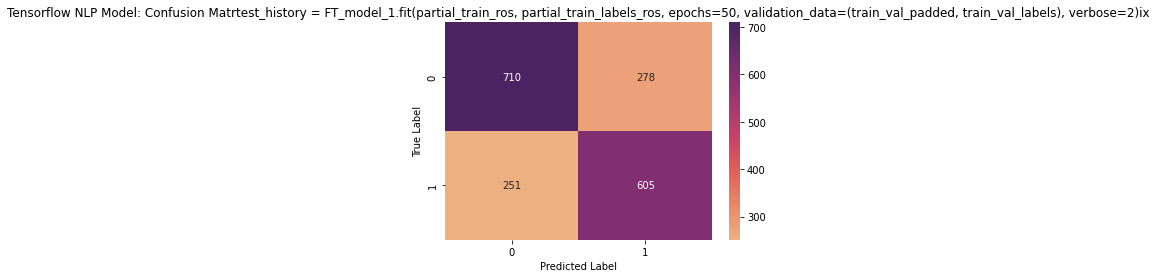

F1 Score:  0.71336360289471


In [ ]:
# visualize perfomance with a confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = (FT_model_1.predict(val_padded) > 0.5).astype("int32")
predictions = [p[0] for p in predictions]
confusion_matrix = tf.math.confusion_matrix(val_labels, predictions)

TP = confusion_matrix.numpy()[0][0]
FP = confusion_matrix.numpy()[0][1]
FN = confusion_matrix.numpy()[1][0]
TN = confusion_matrix.numpy()[1][1]

ax = plt.axes()
sns.heatmap(confusion_matrix, cmap='flare', annot=True, fmt="d", ax = ax)
ax.set_title('Tensorflow NLP Model: Confusion Matrtest_history = FT_model_1.fit(partial_train_ros, partial_train_labels_ros, epochs=50, validation_data=(train_val_padded, train_val_labels), verbose=2)ix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

precise_F1_0 = TP/(TP+FP)
recall_F1_0 = TP/(TP+FN)
F1_0 = (2*precise_F1_0*recall_F1_0)/(recall_F1_0+precise_F1_0)

precise_F1_1 = TN/(TN+FN)
recall_F1_1 = TN/(TN+FP)
F1_1 = (2*precise_F1_1*recall_F1_1)/(recall_F1_1+precise_F1_1)

weight_0 = (TP+FP)/(TP+FP+FN+TN)
weight_1 = (FN+TN)/(TP+FP+FN+TN)
F1_score = F1_0*weight_0+F1_1*weight_1
print("F1 Score: ", F1_score)


(0.0, 0.8714696526527405)

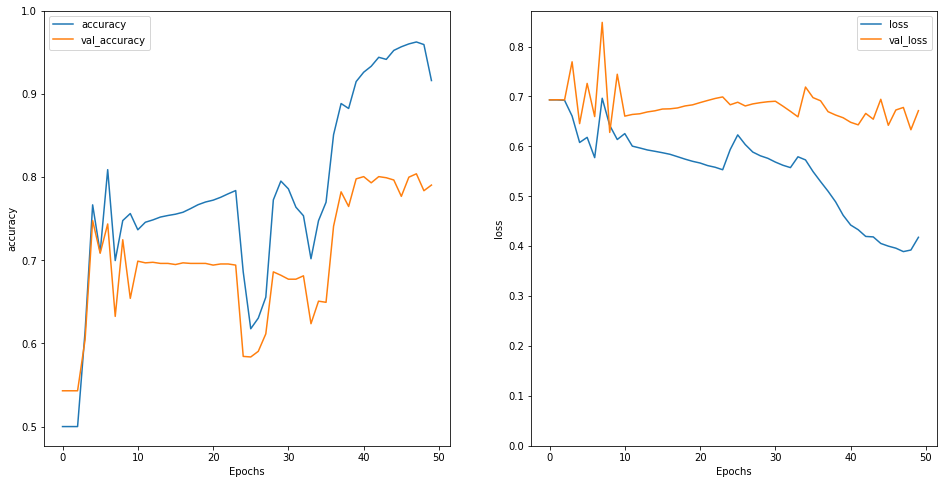

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(FT_model_1_history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(FT_model_1_history, 'loss')
plt.ylim(0, None)

In [ ]:
FT_model_1.save('/content/FT.h5')

# is_Thinking model without ROS

In [ ]:
#is_Thinking model without ros & LSTM(32) & activation(ReLU)
FT_model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=num_unique_words,
        output_dim=16,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

FT_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          5604496   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5,617,105
Trainable params: 5,617,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
FT_model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [ ]:
checkpoint_path = "FT_model_2.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        save_weights_only = True, verbose=1)

FT_model_2_history = FT_model_2.fit(partial_train_padded, partial_train_labels, epochs=50, callbacks=[callbacks], validation_data=(train_val_padded, train_val_labels), verbose=2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)



Epoch 1: saving model to FT_model_2.ckpt
185/185 - 30s - loss: 0.6917 - accuracy: 0.5358 - val_loss: 0.6901 - val_accuracy: 0.5431 - 30s/epoch - 164ms/step
Epoch 2/50

Epoch 2: saving model to FT_model_2.ckpt
185/185 - 13s - loss: 0.6887 - accuracy: 0.5423 - val_loss: 0.6882 - val_accuracy: 0.5431 - 13s/epoch - 68ms/step
Epoch 3/50

Epoch 3: saving model to FT_model_2.ckpt
185/185 - 13s - loss: 0.6849 - accuracy: 0.5423 - val_loss: 0.6851 - val_accuracy: 0.5431 - 13s/epoch - 68ms/step
Epoch 4/50

Epoch 4: saving model to FT_model_2.ckpt
185/185 - 13s - loss: 0.6670 - accuracy: 0.5430 - val_loss: 0.6775 - val_accuracy: 0.5431 - 13s/epoch - 68ms/step
Epoch 5/50

Epoch 5: saving model to FT_model_2.ckpt
185/185 - 13s - loss: 0.6555 - accuracy: 0.5519 - val_loss: 0.6595 - val_accuracy: 0.5451 - 13s/epoch - 71ms/step
Epoch 6/50

Epoch 6: saving model to FT_model_2.ckpt
185/185 - 13s - loss: 0.6115 - accuracy: 0.5641 - val_loss: 0.5873 - val_accuracy: 0.5492 - 13s/epoch - 72ms/step
Epoch 7/

In [ ]:
# Check the accuracy of our model
loss, accuracy = FT_model_2.evaluate(val_padded, val_labels)
print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

58/58 [==============================] - 4s 60ms/step - loss: 0.9118 - accuracy: 0.7093
Model loss on test set: 0.9118157625198364
Model accuracy on test set: 70.93%


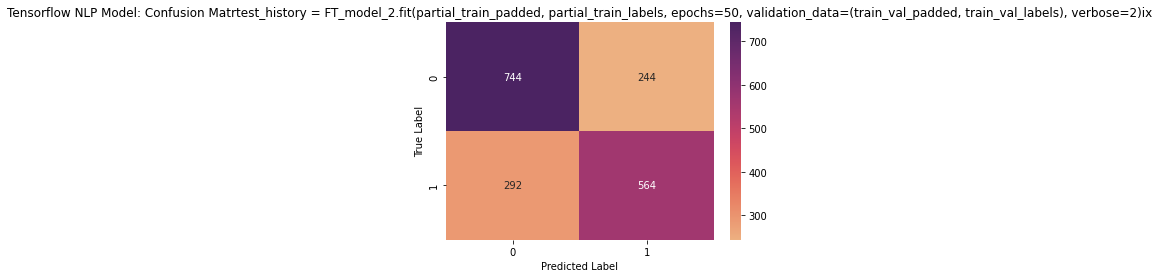

F1 Score:  0.7085818665913923


In [ ]:
# visualize perfomance with a confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = (FT_model_2.predict(val_padded) > 0.5).astype("int32")
predictions = [p[0] for p in predictions]
confusion_matrix = tf.math.confusion_matrix(val_labels, predictions)

TP = confusion_matrix.numpy()[0][0]
FP = confusion_matrix.numpy()[0][1]
FN = confusion_matrix.numpy()[1][0]
TN = confusion_matrix.numpy()[1][1]

ax = plt.axes()
sns.heatmap(confusion_matrix, cmap='flare', annot=True, fmt="d", ax = ax)
ax.set_title('Tensorflow NLP Model: Confusion Matrtest_history = FT_model_2.fit(partial_train_padded, partial_train_labels, epochs=50, validation_data=(train_val_padded, train_val_labels), verbose=2)ix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

precise_F1_0 = TP/(TP+FP)
recall_F1_0 = TP/(TP+FN)
F1_0 = (2*precise_F1_0*recall_F1_0)/(recall_F1_0+precise_F1_0)

precise_F1_1 = TN/(TN+FN)
recall_F1_1 = TN/(TN+FP)
F1_1 = (2*precise_F1_1*recall_F1_1)/(recall_F1_1+precise_F1_1)

weight_0 = (TP+FP)/(TP+FP+FN+TN)
weight_1 = (FN+TN)/(TP+FP+FN+TN)
F1_score = F1_0*weight_0+F1_1*weight_1
print("F1 Score: ", F1_score)


# is_Judging model with ROS

In [ ]:
#Final is_Judging with ros & LSTM(32) & activation(ReLU)
PJ_model_8 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=num_unique_words,
        output_dim=16,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1, activation='ReLU')
])

PJ_model_8.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 16)          5604496   
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,617,105
Trainable params: 5,617,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
PJ_model_8.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = '/content/PJ/-{epoch:01d}-{val_accuracy:.04f}.hdf5'
PJ_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', varbose=1, save_best_only=True)

PJ_model_8_history = PJ_model_8.fit(partial_train_ros, partial_train_labels_ros, epochs=150, callbacks=[PJ_checkpoint], validation_data=(train_val_padded, train_val_labels), verbose=2)

Epoch 1/150
223/223 - 37s - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6940 - val_accuracy: 0.6102 - 37s/epoch - 165ms/step
Epoch 2/150
223/223 - 18s - loss: 0.6918 - accuracy: 0.5000 - val_loss: 0.6953 - val_accuracy: 0.6102 - 18s/epoch - 81ms/step
Epoch 3/150
223/223 - 18s - loss: 0.6897 - accuracy: 0.5062 - val_loss: 0.6988 - val_accuracy: 0.6095 - 18s/epoch - 79ms/step
Epoch 4/150
223/223 - 14s - loss: 0.6489 - accuracy: 0.6099 - val_loss: 0.6998 - val_accuracy: 0.6095 - 14s/epoch - 62ms/step
Epoch 5/150
223/223 - 12s - loss: 0.6477 - accuracy: 0.5760 - val_loss: 0.7001 - val_accuracy: 0.6176 - 12s/epoch - 55ms/step
Epoch 6/150
223/223 - 12s - loss: 0.6164 - accuracy: 0.6969 - val_loss: 0.6845 - val_accuracy: 0.6339 - 12s/epoch - 56ms/step
Epoch 7/150
223/223 - 12s - loss: 0.6465 - accuracy: 0.5586 - val_loss: 0.6913 - val_accuracy: 0.6190 - 12s/epoch - 56ms/step
Epoch 8/150
223/223 - 12s - loss: 0.6147 - accuracy: 0.7074 - val_loss: 0.7104 - val_accuracy: 0.6671 - 12s/epoch - 5

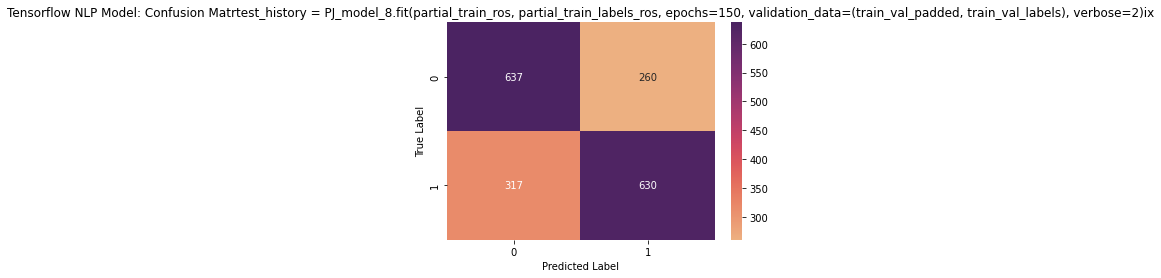

F1 Score:  0.6870565580630168


In [ ]:
# visualize perfomance with a confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = (PJ_model_8.predict(val_padded) > 0.5).astype("int32")
predictions = [p[0] for p in predictions]
confusion_matrix = tf.math.confusion_matrix(val_labels, predictions)

TP = confusion_matrix.numpy()[0][0]
FP = confusion_matrix.numpy()[0][1]
FN = confusion_matrix.numpy()[1][0]
TN = confusion_matrix.numpy()[1][1]

ax = plt.axes()
sns.heatmap(confusion_matrix, cmap='flare', annot=True, fmt="d", ax = ax)
ax.set_title('Tensorflow NLP Model: Confusion Matrtest_history = PJ_model_8.fit(partial_train_ros, partial_train_labels_ros, epochs=150, validation_data=(train_val_padded, train_val_labels), verbose=2)ix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

precise_F1_0 = TP/(TP+FP)
recall_F1_0 = TP/(TP+FN)
F1_0 = (2*precise_F1_0*recall_F1_0)/(recall_F1_0+precise_F1_0)

precise_F1_1 = TN/(TN+FN)
recall_F1_1 = TN/(TN+FP)
F1_1 = (2*precise_F1_1*recall_F1_1)/(recall_F1_1+precise_F1_1)

weight_0 = (TP+FP)/(TP+FP+FN+TN)
weight_1 = (FN+TN)/(TP+FP+FN+TN)
F1_score = F1_0*weight_0+F1_1*weight_1
print("F1 Score: ", F1_score)


In [ ]:
# Check the accuracy of our model
loss, accuracy = PJ_model_8.evaluate(val_padded, val_labels)
print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

58/58 [==============================] - 2s 33ms/step - loss: 1.2290 - accuracy: 0.6871
Model loss on test set: 1.2289659976959229
Model accuracy on test set: 68.71%


(0.0, 1.4248383864760399)

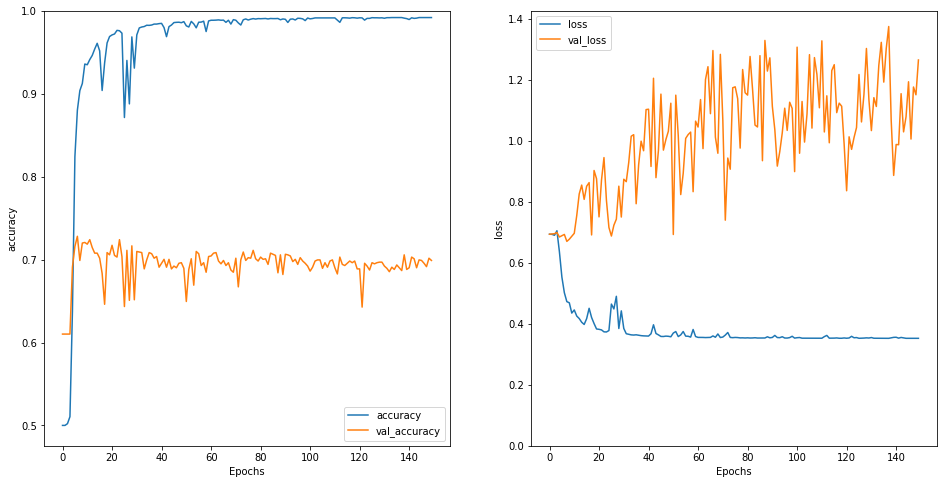

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(PJ_model_8_history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(PJ_model_8_history, 'loss')
plt.ylim(0, None)

In [ ]:
PJ_model_8.save('/content/PJ.h5')

# is_Judging model without ROS

In [ ]:
#is_Judging model without ros & LSTM(32) & activation(ReLU)
PJ_model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=num_unique_words,
        output_dim=16,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1, activation='ReLU')
])

PJ_model_3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 16)          5604496   
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,617,105
Trainable params: 5,617,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
PJ_model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [ ]:
checkpoint_path = "PJ_model_3.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        save_weights_only = True, verbose=1)

PJ_model_3_history = PJ_model_3.fit(partial_train_padded, partial_train_labels, epochs=50, callbacks=[callbacks], validation_data=(train_val_padded, train_val_labels), verbose=2)

Epoch 1/50

Epoch 1: saving model to PJ_model_3.ckpt
185/185 - 38s - loss: 0.6932 - accuracy: 0.6029 - val_loss: 0.6932 - val_accuracy: 0.6102 - 38s/epoch - 205ms/step
Epoch 2/50

Epoch 2: saving model to PJ_model_3.ckpt
185/185 - 13s - loss: 0.6931 - accuracy: 0.6029 - val_loss: 0.6932 - val_accuracy: 0.6102 - 13s/epoch - 68ms/step
Epoch 3/50

Epoch 3: saving model to PJ_model_3.ckpt
185/185 - 13s - loss: 0.6931 - accuracy: 0.6029 - val_loss: 0.6932 - val_accuracy: 0.6102 - 13s/epoch - 68ms/step
Epoch 4/50

Epoch 4: saving model to PJ_model_3.ckpt
185/185 - 13s - loss: 0.6928 - accuracy: 0.6029 - val_loss: 0.6933 - val_accuracy: 0.6102 - 13s/epoch - 68ms/step
Epoch 5/50

Epoch 5: saving model to PJ_model_3.ckpt
185/185 - 13s - loss: 0.6921 - accuracy: 0.6029 - val_loss: 0.6934 - val_accuracy: 0.6102 - 13s/epoch - 68ms/step
Epoch 6/50

Epoch 6: saving model to PJ_model_3.ckpt
185/185 - 13s - loss: 0.6890 - accuracy: 0.6046 - val_loss: 0.6926 - val_accuracy: 0.6095 - 13s/epoch - 68ms/st

In [ ]:
# Check the accuracy of our model
loss, accuracy = PJ_model_3.evaluate(val_padded, val_labels)
print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

58/58 [==============================] - 2s 42ms/step - loss: 0.6482 - accuracy: 0.6188
Model loss on test set: 0.6482255458831787
Model accuracy on test set: 61.88%


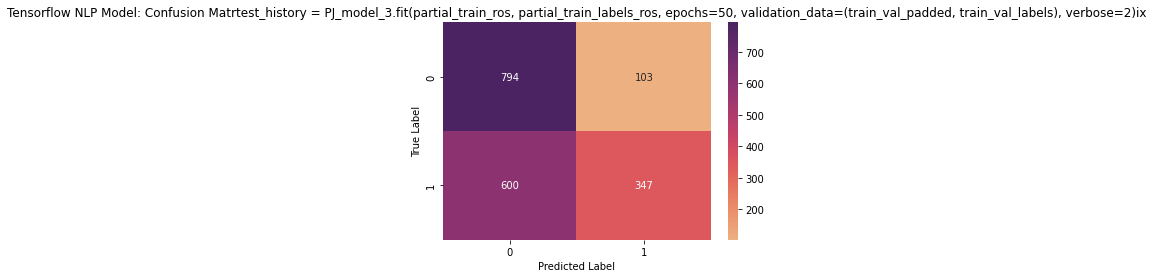

F1 Score:  0.5923006947011419


In [ ]:
# visualize perfomance with a confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = (PJ_model_3.predict(val_padded) > 0.5).astype("int32")
predictions = [p[0] for p in predictions]
confusion_matrix = tf.math.confusion_matrix(val_labels, predictions)

TP = confusion_matrix.numpy()[0][0]
FP = confusion_matrix.numpy()[0][1]
FN = confusion_matrix.numpy()[1][0]
TN = confusion_matrix.numpy()[1][1]

ax = plt.axes()
sns.heatmap(confusion_matrix, cmap='flare', annot=True, fmt="d", ax = ax)
ax.set_title('Tensorflow NLP Model: Confusion Matrtest_history = PJ_model_3.fit(partial_train_ros, partial_train_labels_ros, epochs=50, validation_data=(train_val_padded, train_val_labels), verbose=2)ix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

precise_F1_0 = TP/(TP+FP)
recall_F1_0 = TP/(TP+FN)
F1_0 = (2*precise_F1_0*recall_F1_0)/(recall_F1_0+precise_F1_0)

precise_F1_1 = TN/(TN+FN)
recall_F1_1 = TN/(TN+FP)
F1_1 = (2*precise_F1_1*recall_F1_1)/(recall_F1_1+precise_F1_1)

weight_0 = (TP+FP)/(TP+FP+FN+TN)
weight_1 = (FN+TN)/(TP+FP+FN+TN)
F1_score = F1_0*weight_0+F1_1*weight_1
print("F1 Score: ", F1_score)
